In [1]:
from catboost import Pool, CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

In [2]:
def parse_csv(path, col_name, start_index=0):
    df = pd.read_csv(path, decimal=',')
    list_of_df = []
    for i in range(len(df)):
        new_df = df.iloc[i,:].to_frame(name=col_name).reset_index()
        if col_name == 'flammability':
            new_df = df.iloc[i,:].to_frame(name="flammability").reset_index()
            new_df['region'] = new_df.iloc[1,1]
            new_df['OSM_ID'] = new_df.iloc[0,1]
            new_df = new_df.iloc[3:,:]
            list_of_df.append(new_df)
        else:
            new_df['OSM_ID'] = new_df.iloc[0,1]
            new_df = new_df.iloc[1:,:]
            list_of_df.append(new_df)
    
    df = pd.concat(list_of_df).reset_index()
    df = df.rename(columns={"index": "year"})
    df = df.drop(['level_0'], axis=1)
    return df

list_of_df = [parse_csv('data/flam_dynamics.csv', 'flammability', 1),
              parse_csv('data/NDVI_dynamics.csv', 'NDVI'),
              parse_csv('data/precip_dynamics.csv', 'precipitation'),
              parse_csv('data/pre_begg_year.csv','precip_beggining_y'),
              parse_csv('data/stock_dynamics.csv','livestock'),
              parse_csv('data/t_max_dynamics.csv','t_max')]
list_of_df[0]

,year,flammability,region,OSM_ID
0,2001,28.62,Ахтубинский район,-1850408
1,2002,15.94,Ахтубинский район,-1850408
2,2003,0.66,Ахтубинский район,-1850408
3,2004,2.52,Ахтубинский район,-1850408
4,2005,11.46,Ахтубинский район,-1850408
...,...,...,...,...
1155,2016,0.0,Уральск Г.А.,-3767383
1156,2017,1.25,Уральск Г.А.,-3767383
1157,2018,4.8,Уральск Г.А.,-3767383
1158,2019,0.0,Уральск Г.А.,-3767383


In [3]:
df_subjects = pd.read_csv('data/flam_dynamics.csv', decimal=',')
df_subjects['Region'].unique()

array(['AST', 'ATY', 'KL', 'SAR', 'VGG', 'ZKO'], dtype=object)

In [4]:
df_subjects.head()

,OSM_ID,NAME,Region,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,-1850408,Ахтубинский район,AST,28.62,15.94,0.66,2.52,11.46,16.28,3.77,...,2.11,4.00,0.0,16.59,1.42,2.39,20.90,0.74,2.68,4.33
1,-1863175,Володарский район,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-1853865,городской округ Астрахань,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-1853856,Енотаевский район,AST,10.63,7.04,2.07,3.16,2.48,13.61,1.58,...,2.95,1.01,0.0,1.54,0.00,0.14,0.18,0.00,0.12,0.00
4,-1957534,Икрянинский район,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


![title](img/UFO1_pol.jpg)

![title](img/kaz_pol.png)

In [5]:
df_region = pd.read_csv('data/Municipals.csv', encoding="windows-1251", delimiter=';', decimal=',')
df_region = df_region.drop(['Region','NAME', 'Area_ha'], axis=1)

In [6]:
import functools as ft
df = ft.reduce(lambda left, right: pd.merge(left, right, on=['OSM_ID','year']), list_of_df)

In [7]:
df = df.merge(df_region, on=['OSM_ID'])
df.head()

,year,flammability,region,OSM_ID,NDVI,precipitation,precip_beggining_y,livestock,t_max,N,E
0,2001,28.62,Ахтубинский район,-1850408,3443.553826,305.300003,87.550,NaN,22.864286,48.288975,46.400784
1,2002,15.94,Ахтубинский район,-1850408,3283.658314,327.975006,99.725,NaN,22.464286,48.288975,46.400784
2,2003,0.66,Ахтубинский район,-1850408,2986.687553,318.075005,67.300,NaN,20.989285,48.288975,46.400784
3,2004,2.52,Ахтубинский район,-1850408,3269.350491,319.725006,110.125,NaN,22.935715,48.288975,46.400784
4,2005,11.46,Ахтубинский район,-1850408,3305.540993,312.275009,104.125,NaN,22.800001,48.288975,46.400784


![title](img/ndvi.png)
t_max - динамика максимальных температур за год  
precipitation - динамика кол-ва осадков  
livestock - динамика поголовья скота  
NDVI - динамика нормализованного относительного индекса растительности

In [8]:
df = df.fillna(-9999)
df['flammability'] = df['flammability'] + 0.001
df['flammability'] = np.log1p(df['flammability'])

In [9]:
df['previous_precipitation'] = df['precipitation'].shift(+1)
df.loc[df['year'] == '2001', 'previous_precipitation'] = np.nan
df['previous_precipitation'] = df.groupby(['region']).previous_precipitation.transform(lambda x: x.fillna(x.mean()))

df['previous_NDVI'] = df['NDVI'].shift(+1)
df.loc[df['year'] == '2001', 'previous_NDVI'] = np.nan
df['previous_NDVI'] = df.groupby(['region']).previous_NDVI.transform(lambda x: x.fillna(x.mean()))

Почему мы используем смещенные показали? Т.к. все показатели считаются на конец года, логично использовать смещенные данные, из практических целей это означает, что нам интересны условия предыдущего.

In [10]:
df = df.drop(['OSM_ID', 'year', 'region','precipitation', 'NDVI'], axis=1)

In [11]:
df.corr()

,flammability,precip_beggining_y,livestock,t_max,N,E,previous_precipitation,previous_NDVI
flammability,1.000000,0.083248,-0.084292,-0.159731,0.267537,0.226668,0.162518,-0.060377
precip_beggining_y,0.083248,1.000000,-0.191734,-0.556116,0.586401,-0.310281,0.643844,0.297560
livestock,-0.084292,-0.191734,1.000000,0.258289,0.050272,0.252426,-0.229481,-0.154396
t_max,-0.159731,-0.556116,0.258289,1.000000,-0.722567,0.169685,-0.675375,-0.332866
N,0.267537,0.586401,0.050272,-0.722567,1.000000,0.186965,0.540030,0.151696
E,0.226668,-0.310281,0.252426,0.169685,0.186965,1.000000,-0.423663,-0.349497
previous_precipitation,0.162518,0.643844,-0.229481,-0.675375,0.540030,-0.423663,1.000000,0.521256
previous_NDVI,-0.060377,0.297560,-0.154396,-0.332866,0.151696,-0.349497,0.521256,1.000000


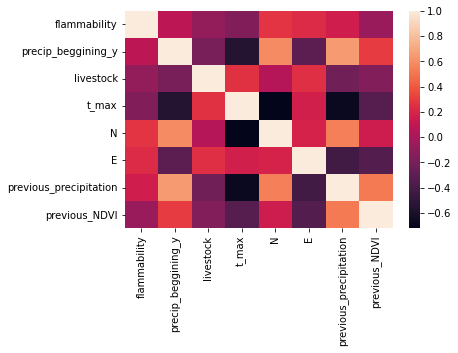

In [12]:
uniform_data = np.random.rand(20, 15)
ax = sns.heatmap(df.corr())

In [13]:
col_names = ['livestock', 't_max', 'precip_beggining_y', 'previous_precipitation','N','E', 'previous_NDVI']
X = df[col_names]
cv = 10
scalers = (RobustScaler(), StandardScaler(), MinMaxScaler())

regressors = (
    RidgeCV(cv=cv, alphas=[0.0001, 0.001,0.01, 0.1, 1]), 
    LassoCV(cv=cv, alphas=[0.0001, 0.001,0.01, 0.1, 1], n_alphas=[100, 200, 300, 400]), 
    ElasticNetCV(cv=cv, alphas=[0.0001, 0.001,0.01, 0.1, 1, 10], n_alphas=[100, 200, 300, 400])
)

for scaler in scalers:
    for regressor in regressors:
        ct = ColumnTransformer([('scaler', scaler, ['livestock', 't_max', 'precip_beggining_y',
                                                    'previous_precipitation', 'previous_NDVI'])], remainder='passthrough')
        X_scaled = ct.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['flammability'], test_size=0.20, random_state=42)               
        
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        
        print('R2: ' + str(regressor.score(X_test, y_test)))
        print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
        print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
        print('Scaler: ' + scaler.__class__.__name__)
        print('Regressor\'s type:' + regressor.__class__.__name__)
        print('Best Alpha: ' + str(regressor.alpha_))
        print()
#         for col, coef in zip(df.columns, regressor.coef_):
#             print(col, coef)
        print('==' * 20)

R2: 0.13770300141683156
RMSE: 0.9052191836839125
MAE: 0.7508340533681169
Scaler: RobustScaler
Regressor's type:RidgeCV
Best Alpha: 1.0

R2: 0.13748701137442498
RMSE: 0.9053325472281789
MAE: 0.7508089532115134
Scaler: RobustScaler
Regressor's type:LassoCV
Best Alpha: 0.0001

R2: 0.1375781685832872
RMSE: 0.9052847046044484
MAE: 0.75111944188133
Scaler: RobustScaler
Regressor's type:ElasticNetCV
Best Alpha: 0.001

R2: 0.13755640745721032
RMSE: 0.9052961258658345
MAE: 0.7508205527672481
Scaler: StandardScaler
Regressor's type:RidgeCV
Best Alpha: 1.0

R2: 0.13745949199394525
RMSE: 0.9053469899046553
MAE: 0.7508129312097505
Scaler: StandardScaler
Regressor's type:LassoCV
Best Alpha: 0.0001

R2: 0.13747423465083497
RMSE: 0.9053392527161128
MAE: 0.7507845024733393
Scaler: StandardScaler
Regressor's type:ElasticNetCV
Best Alpha: 0.0001

R2: 0.13784150994345934
RMSE: 0.9051464792613605
MAE: 0.7508567808056238
Scaler: MinMaxScaler
Regressor's type:RidgeCV
Best Alpha: 0.1

R2: 0.13750157557428144


In [14]:
#Test Default CatBoost
print("Testing default Catboost")

scalers = (RobustScaler(), StandardScaler(), MinMaxScaler())
for scaler in scalers:
    
    ct = ColumnTransformer([('scaler', scaler, ['livestock', 't_max', 'precip_beggining_y', 
                                                'previous_precipitation', 'previous_NDVI'])], remainder='passthrough')
    
    X_scaled = ct.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        df['flammability'], 
                                                        test_size=0.20, random_state=42)  
    model = CatBoostRegressor(logging_level='Silent')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    
    print('R2: ' + str(r2))
    print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
    print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
    print('Scaler: ' + scaler.__class__.__name__)
    #print(model.get_all_params())
    print('==' * 20)
for x, y in zip(df.drop(['flammability'], axis=1), model.get_feature_importance()):
    print(x, y)

Testing default Catboost
R2: 0.5889272973079902
RMSE: 0.9052393715196821
MAE: 0.7509158052457539
Scaler: RobustScaler
R2: 0.5935277930676568
RMSE: 0.9052393715196821
MAE: 0.7509158052457539
Scaler: StandardScaler
R2: 0.6017152913908765
RMSE: 0.9052393715196821
MAE: 0.7509158052457539
Scaler: MinMaxScaler
precip_beggining_y 16.05281047607367
livestock 9.0647320021717
t_max 9.352330399873694
N 10.913813689820525
E 9.735801779680092
previous_precipitation 20.433671309983858
previous_NDVI 24.446840342396456


In [15]:
scaler = MinMaxScaler()
ct = ColumnTransformer([('scaler', scaler, ['livestock', 't_max', 'precip_beggining_y',
                                                'previous_precipitation', 'previous_NDVI'])], remainder='passthrough')
X_scaled = ct.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    df['flammability'], 
                                                    test_size=0.20, random_state=42)
model = CatBoostRegressor(logging_level='Silent')

grid = { 
        'learning_rate': [0.03, 0.04, 0.045, 0.47, 0.403],
        'depth': [4, 6, 8, 10, 15],
        'l2_leaf_reg': [2, 3, 4, 5, 7, 10, 12],
        'iterations': [250, 300, 500]
       }

grid_search = model.grid_search(grid, X=X_train, y=y_train, plot=True, verbose=False)
#grid.fit(X_train, y_train)

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))

r2 = r2_score(y_test, pred)
print('R2: ' + str(r2))
print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
print('Scaler: ' + scaler.__class__.__name__)
print('Best params: ' + str(grid_search['params']))
print('==' * 20)
for x, y in zip(df.drop(['flammability'], axis=1), model.get_feature_importance()):
    print(x, y)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2: 0.5836983098697024
RMSE: 0.9052393715196821
MAE: 0.7509158052457539
Scaler: MinMaxScaler
Best params: {'depth': 6, 'l2_leaf_reg': 2, 'iterations': 500, 'learning_rate': 0.03}
precip_beggining_y 15.87272979424634
livestock 8.00560501397112
t_max 7.8128353470754694
N 10.634228656357406
E 9.517090408229034
previous_precipitation 22.006339948499868
previous_NDVI 26.15117083162074


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        df['flammability'], 
                                                        test_size=0.20, random_state=42)

param_grid = {
    'C': [1, 5, 100, 200, 1000],
    'epsilon': [0.01, 0.1, 0.05, 0.0003, 1, 0.2, 5, 10],
    'gamma': [0.001, 0.1, 1, 5, 10, 100]
}
grid_search = GridSearchCV(estimator = SVR(), param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 0)
regr = make_pipeline(RobustScaler(), grid_search)


regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))
print(regr[1].best_params_)

0.4652998765730475
{'C': 100, 'epsilon': 0.05, 'gamma': 0.1}


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        df['flammability'], 
                                                        test_size=0.20, random_state=42)
knn = KNeighborsRegressor()
k_range = list(range(1, 50))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, verbose=1)

# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_estimator_)
grid.score(X_test, y_test)

Fitting 10 folds for each of 49 candidates, totalling 490 fits
KNeighborsRegressor(n_neighbors=7)


0.4788937096619005

Что можно сделать ещё?

1. Поискать ещё признаки.
1. Выяснить для каких районов/регионов мы хорошо предсказываем горимость.
2. Добавить карт.